In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pygus import Species, tree_population_from_geojson, latlng_array_to_xy

In [2]:
species_dist = {
  "Acer campestre": 0.05,
  "Betula pendula": 0.05,
  "Betula pubescens": 0.05,
  "Carpinus betulus": 0.05,
  "Cornus sanguinea": 0.07,
  "Corylus avellana": 0.1,
  "Euonymus europaeus": 0.05,
  "Malus sylvestris": 0.05,
  "Prunus avium": 0.05,
  "Prunus spinosa": 0.05,
  "Quercus petraea": 0.02,
  "Quercus robur": 0.02,
  "Rosa canina": 0.05,
  "Salix caprea": 0.05,
  "Salix cinerea": 0.05,
  "Sambucus nigra": 0.07,
  "Sorbus aria": 0.05,
  "Sorbus torminalis": 0.05,
  "Tilia cordata": 0.02,
  "Viburnum opulus": 0.05
}

species = species_dist.keys()
ratios = species_dist.values()

In [3]:
sites = [
    {"name": "Forest of Thanks", "trees": 30000, "lat": 51.546514, "lng": 0.126283, "shape": "input/forest_of_thanks.geojson"},
    {"name": "Castle Green Forest", "trees": 1400, "lat": 51.532997, "lng": 0.119295, "shape": "input/castle_green_forest.geojson"},
    {"name": "Thames View Junior", "trees": 1200, "lat": 51.526769, "lng": 0.102509, "shape": "input/thames_view_junior.geojson"},
]

In [4]:
from shapely import from_geojson
from pkg_resources import resource_filename
allometrics_path = resource_filename("pygus", "gus/inputs/allometrics_extended.json")
species_allometrics = Species(allometrics_path)
species_map = {}
# check how many are in our allometrics file, and highlight ones that are not
for s in species:
    species_map[s] = species_allometrics.fuzzymatch(s)

print(species_map)

{'Acer campestre': 'acer campestre', 'Betula pendula': 'betula pendula', 'Betula pubescens': 'betula pubescens', 'Carpinus betulus': 'carpinus betulus', 'Cornus sanguinea': 'cornus sanguinea', 'Corylus avellana': 'corylus avellana', 'Euonymus europaeus': 'fraxinus excelsior', 'Malus sylvestris': 'malus sylvestris', 'Prunus avium': 'prunus avium', 'Prunus spinosa': 'prunus spinosa', 'Quercus petraea': 'quercus petraea', 'Quercus robur': 'quercus robur', 'Rosa canina': 'decidu', 'Salix caprea': 'salix caprea', 'Salix cinerea': 'salix cinerea', 'Sambucus nigra': 'quercus nigra', 'Sorbus aria': 'sorbus aria', 'Sorbus torminalis': 'sorbus torminalis', 'Tilia cordata': 'tilia cordata', 'Viburnum opulus': 'decidu'}


In [5]:
for site in sites:
    # for each site, generate a population, load the geojson
    shapely_geojson = from_geojson(open(site["shape"]).read())
    print(shapely_geojson)


    # generate population within each geojson
    site_df = tree_population_from_geojson(
        shapely_geojson, 
        site["trees"], 
        allometrics=species_allometrics,
        species=species_dist,
        dbh_range=[0.5, 1.5],
        condition_weights=[0.8, 0.2, 0.0, 0.0, 0.0]
    )
    site["df"] = site_df
    
    site_df.to_csv(f"output/{site['name']}.csv", index=False)

    print(site_df["dbh"].describe())
    print(site_df["height"].describe())
    # print the top 5 rows sorted by height
    print(site_df.sort_values("height", ascending=False).head(5))


# trees_CGf = from_geojson(open(sites[1]["shape"]).read())
# trees_TVj = from_geojson(open(sites[2]["shape"]).read())
    


MULTIPOLYGON (((0.1273308912034281 51.5468999931085, 0.1271949353328807 51.546920017465595, 0.1270589794849286 51.54694004182977, 0.1269337569938784 51.546944491689885, 0.1268228456405041 51.54692891717414, 0.1267927184590292 51.54692446731397, 0.1267198891399346 51.54690925097901, 0.1266089777905961 51.5468736520688, 0.1265231109452998 51.54683137833294, 0.1264730219491241 51.54680022924006, 0.1264229329518969 51.54675350556042, 0.1265231109452998 51.54673125617239, 0.1265875110993875 51.546706781814464, 0.1266698001644784 51.54666673286658, 0.1267342003114891 51.54663558364385, 0.126784636621629 51.54660633642547, 0.1268493840722584 51.54664828743128, 0.1269717234042957 51.546705490070536, 0.1271566739812329 51.54682387846472, 0.1273308912034281 51.5468999931085)), ((0.1270965669326927 51.546583257401835, 0.1272074782831112 51.546545433296075, 0.1272647228496453 51.54650760915803, 0.1273112340611533 51.54645643527161, 0.1273505897013365 51.546403036373135, 0.1275402123312119 51.54644

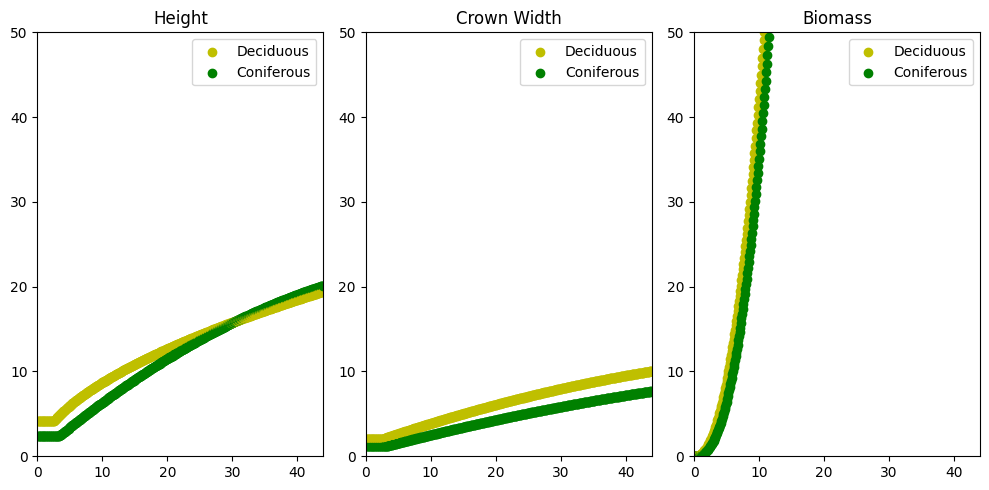

In [6]:
import matplotlib.pyplot as plt
import numpy as np

h_decidu = species_allometrics.get_eqn("decidu", "height")
h_conif = species_allometrics.get_eqn("conifer", "height")

biomass_decidu = species_allometrics.get_eqn_biomass("decidu")
biomass_conif = species_allometrics.get_eqn_biomass("conifer")

crownWidth_decidu = species_allometrics.get_eqn("decidu", "crown_width")
crownWidth_conif = species_allometrics.get_eqn("conifer", "crown_width")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # Create figure and subplots outside the loop

# Set titles
axs[0].set_title("Height")
axs[1].set_title("Crown Width")
axs[2].set_title("Biomass")

# Set x and y limits
for ax in axs:
    ax.set_xlim(0, 44)
    ax.set_ylim(0, 50)

# Plot data
for i in np.arange(0.1, 44, 0.1):
    axs[0].scatter(i, h_decidu(i), color='y')  # Plot height for deciduous
    axs[0].scatter(i, h_conif(i), color='g')  # Plot height for coniferous
    axs[1].scatter(i, crownWidth_decidu(i), color='y')  # Plot crown width for deciduous
    axs[1].scatter(i, crownWidth_conif(i), color='g')  # Plot crown width for coniferous
    axs[2].scatter(i, biomass_decidu(i), color='y')  # Plot biomass for deciduous
    axs[2].scatter(i, biomass_conif(i), color='g')  # Plot biomass for conifer

# Set legends
axs[0].legend(["Deciduous", "Coniferous"])
axs[1].legend(["Deciduous", "Coniferous"])
axs[2].legend(["Deciduous", "Coniferous"])

plt.tight_layout()
plt.show()

In [7]:
# Below I'll plot the distributions of: DBH, height, and lat/lng
def plot_dbh_height_and_latlng(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("DBH, Height, and Lat/Lng Distributions")
    axs[0].hist(df["dbh"], bins=20)
    axs[0].set_title("DBH Distribution")
    axs[1].hist(df["height"], bins=20)
    axs[1].set_title("Height Distribution")
    axs[2].scatter(df["lat"], df["lng"])
    axs[2].set_title("Tree Locations")
    plt.show()

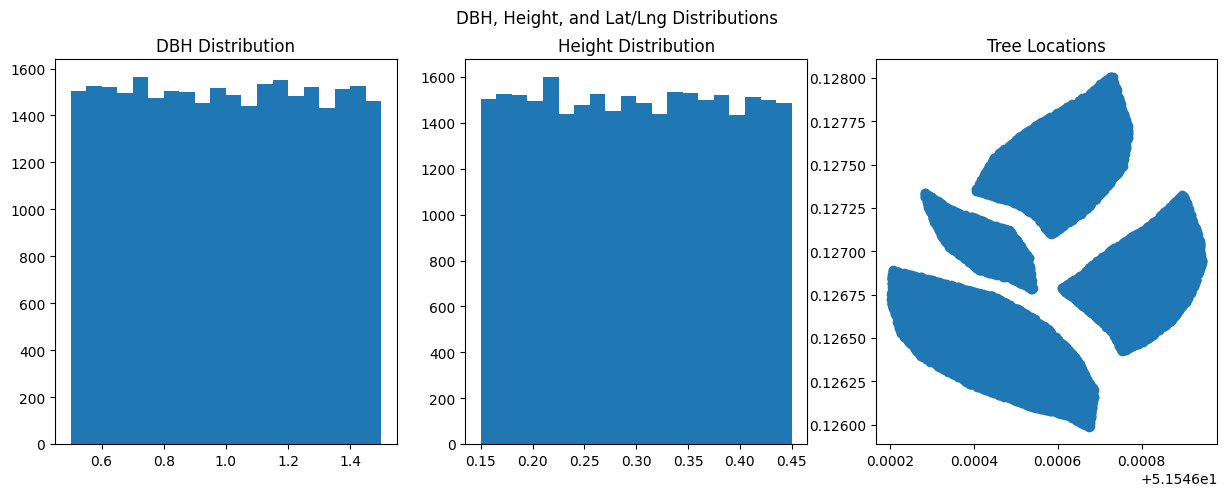

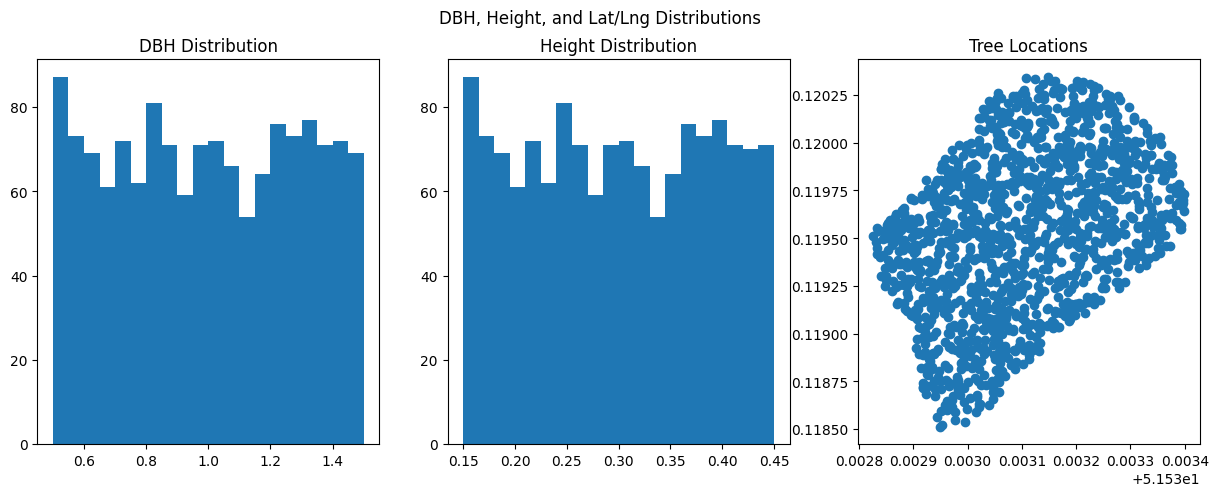

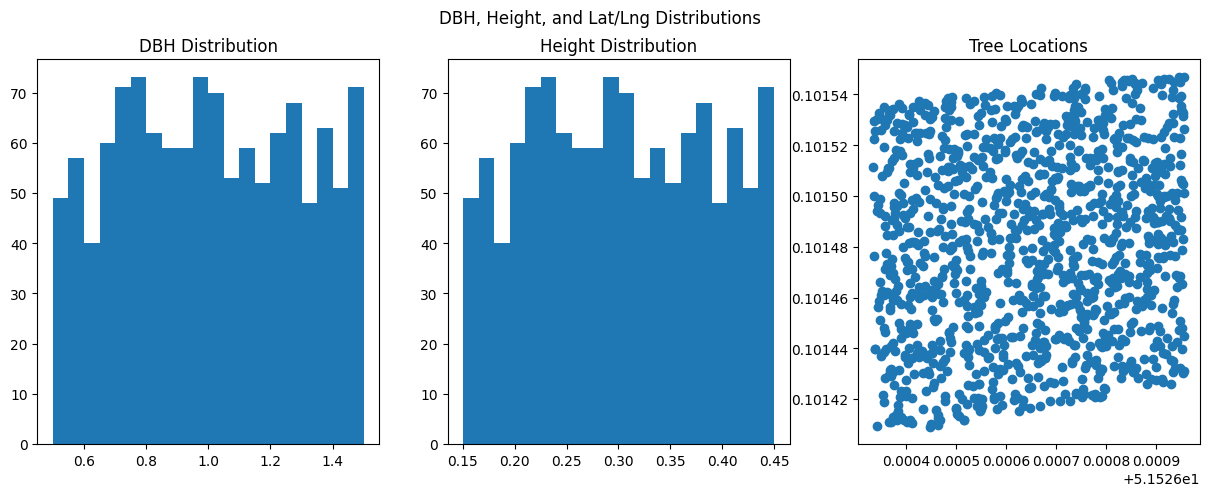

In [8]:
for site in sites:
    df = pd.read_csv(f"output/{site['name']}.csv")
    plot_dbh_height_and_latlng(df)

In [9]:
# TODO
from pygus import Urban, SiteConfig, ScenarioConfig, WeatherConfig

df_thanks = sites[0]["df"]
df_castle = sites[1]["df"]
df_thames = sites[2]["df"]

In [10]:
df_thanks.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.546806,0.127015,72,67,1.166,0.3498,Sambucus nigra,excellent
1,1,51.546462,0.126255,18,30,0.758,0.2274,Cornus sanguinea,excellent
2,2,51.546869,0.126809,58,74,1.365,0.4095,Betula pubescens,excellent
3,3,51.546255,0.126510,35,7,0.905,0.2715,Cornus sanguinea,excellent
4,4,51.546667,0.126116,9,54,1.160,0.3480,Acer campestre,good


In [11]:
df_castle.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.532971,0.119499,68,16,0.724,0.2172,Carpinus betulus,excellent
1,1,51.532877,0.119364,59,6,0.710,0.2130,Sorbus aria,excellent
2,2,51.533053,0.118811,21,27,1.313,0.3939,Quercus robur,good
3,3,51.532969,0.119695,82,15,0.640,0.1920,Rosa canina,excellent
4,4,51.533184,0.119606,77,39,0.951,0.2853,Betula pubescens,excellent


In [12]:
df_thames.head()

,id,lat,lng,xpos,ypos,dbh,height,species,condition
0,0,51.526584,0.101520,8,28,1.270,0.3810,Corylus avellana,excellent
1,1,51.526852,0.101536,11,58,0.575,0.1725,Prunus avium,excellent
2,2,51.526350,0.101461,3,2,0.673,0.2019,Betula pendula,excellent
3,3,51.526773,0.101523,10,49,0.537,0.1611,Salix cinerea,excellent
4,4,51.526418,0.101525,8,10,0.650,0.1950,Salix cinerea,good


In [13]:
site_config_miyawaki = SiteConfig(
    total_m2=100,
    impervious_m2=0,
    pervious_m2=100,
    weather=WeatherConfig(
        growth_season_mean=155,
        growth_season_var=7,
    ),
    tree_density_per_ha=5,
    project_site_type="park",
    light_loss_multiplier = 0.1
)

site_config_urban = SiteConfig(
    total_m2=1000,
    impervious_m2=0,
    pervious_m2=1000,
    weather=WeatherConfig(
        growth_season_mean=155,
        growth_season_var=7,
    ),
    tree_density_per_ha=5,
    project_site_type="park",
    light_loss_multiplier = 0.75
)

# SCENARIO
scenario_config = ScenarioConfig(
    1,
    is_crownsunexposure_fixed=1,
    time_horizon_years=50,
)

In [14]:

#Initialise the model environment
urban = Urban(
    population=df_thames,
    species_allometrics=species_allometrics,
    site_config=site_config_urban,
    scenario=scenario_config,
)
df_urban = urban.run()


In [15]:

miyawaki = Urban(
    population=df_castle,
    species_allometrics=species_allometrics,
    site_config=site_config_miyawaki,
    scenario=scenario_config,
)
df_miyawaki = miyawaki.run()

In [16]:
df_miyawaki.tail()

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std,Cum_Seq
45,200886.524565,5905.114165,4.793112,3659.413928,2.871511,1232,168,0,0,0,3750,3.607732,200223.541933
46,207417.988459,6520.623675,5.254330,2741.425660,2.029112,1241,159,0,0,0,3830,3.933476,206744.165608
47,213948.141847,6520.411526,5.179040,2403.689683,1.982196,1259,141,0,0,0,3912,3.897635,213264.577134
48,220284.701159,6327.640188,5.058066,3264.836132,2.560193,1251,149,0,0,0,3989,3.785371,219592.217322
49,226681.798311,6387.058388,5.069094,3327.127047,2.667751,1260,140,0,0,0,4066,3.758352,225979.275710


In [17]:
df_urban.tail()

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std,Cum_Seq
45,28116.549738,434.795760,0.422953,546.661905,0.519284,1028,172,0,0,0,3590,0.809436,27503.338646
46,28571.626394,444.836082,0.435260,195.909295,0.187094,1022,178,0,0,0,3666,0.828407,27948.174728
47,29064.148003,482.299396,0.462859,268.790175,0.285675,1042,158,0,0,0,3753,0.907140,28430.474124
48,29486.348261,412.030218,0.398482,598.711423,0.592478,1034,166,0,0,0,3830,0.799315,28842.504342
49,29887.382701,390.653233,0.384123,367.553742,0.361114,1017,183,0,0,0,3912,0.791254,29233.157575


<Axes: >

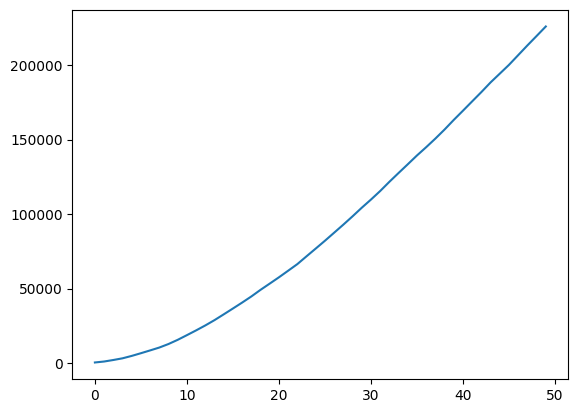

In [18]:
df_miyawaki.Cum_Seq.plot()

<Axes: >

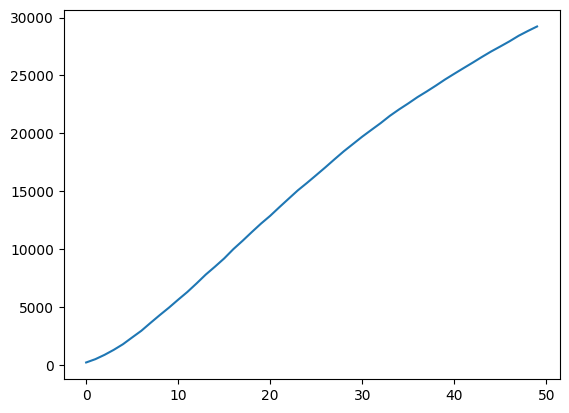

In [19]:
df_urban.Cum_Seq.plot()

In [20]:
agents_df = urban.get_agent_data()
agents_df.reset_index(inplace=True)
agents_df.head(20)

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
0,1,0,corylus avellana,1.797388,4.283814,2.303374,2.023323,0.962929,0.636144,excellent,...,0.442889,0.0,0.0,0.000163,0.000000,8,28,2,51.526584,0.101520
1,1,1,prunus avium,1.237867,4.283814,2.303374,2.023323,0.550245,0.793658,excellent,...,0.191351,0.0,0.0,0.000000,0.000000,11,58,2,51.526852,0.101536
2,1,2,betula pendula,1.357712,4.283814,2.303374,2.023323,0.463280,0.824986,excellent,...,0.235581,0.0,0.0,0.000074,0.000000,3,2,2,51.526350,0.101461
3,1,3,salix cinerea,1.163574,4.283814,2.303374,2.023323,0.608646,0.755809,excellent,...,0.166474,0.0,0.0,0.000062,0.000000,10,49,2,51.526773,0.101523
4,1,4,salix cinerea,1.214345,4.283814,2.303374,2.023323,0.687806,0.741153,good,...,0.183267,0.0,0.0,0.000809,0.000000,8,10,2,51.526418,0.101525
5,1,5,carpinus betulus,1.504985,4.283814,2.303374,2.023323,0.275122,0.896829,good,...,0.297017,0.0,0.0,0.001151,0.000000,9,5,2,51.526374,0.101534
6,1,6,cornus sanguinea,1.033777,4.283814,2.303374,2.023323,0.820183,0.684857,fair,...,0.127573,0.0,0.0,0.000638,0.000000,5,53,2,51.526806,0.101462
7,1,7,prunus spinosa,1.794398,4.283814,2.303374,2.023323,1.000000,0.510428,excellent,...,0.441233,0.0,0.0,0.000151,0.000000,6,49,2,51.526771,0.101474
8,1,8,fraxinus excelsior,1.103688,3.887074,2.303374,0.583195,1.000000,0.478663,excellent,...,0.073343,0.0,0.0,0.000010,0.000000,6,31,2,51.526609,0.101484
9,1,9,corylus avellana,1.698680,4.283814,2.303374,2.023323,0.550245,0.791820,good,...,0.390029,0.0,0.0,0.000196,0.000000,6,15,2,51.526466,0.101487


In [21]:
agents_df.tail(200)

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
157817,50,4912,decidu,1.301507,4.433814,2.303374,2.023323,1.0,0.00,excellent,...,0.214203,0.0,0.0,0.000076,0.0,7,37,3,51.526659,0.101491
157818,50,4913,quercus nigra,0.592791,5.413736,2.267438,1.939412,1.0,0.00,excellent,...,0.036498,0.0,0.0,0.000014,0.0,8,6,3,51.526389,0.101522
157819,50,4914,prunus spinosa,1.011306,4.433814,2.303374,2.023323,1.0,0.00,excellent,...,0.121418,0.0,0.0,0.000006,0.0,3,29,3,51.526594,0.101438
157820,50,4915,corylus avellana,1.478164,4.433814,2.303374,2.023323,1.0,0.00,excellent,...,0.285239,0.0,0.0,0.000047,0.0,5,61,3,51.526876,0.101459
157821,50,4916,quercus petraea,1.092888,4.433814,2.303374,2.023323,1.0,0.00,excellent,...,0.144577,0.0,0.0,0.000026,0.0,3,39,3,51.526676,0.101442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158012,50,5107,salix cinerea,1.374787,4.133814,2.303374,2.023323,0.0,0.56,excellent,...,0.242301,0.0,0.0,0.000000,0.0,6,2,1,51.526348,0.101493
158013,50,5108,cornus sanguinea,0.621167,4.133814,2.303374,2.023323,0.0,0.56,excellent,...,0.040548,0.0,0.0,0.000000,0.0,7,38,1,51.526674,0.101493
158014,50,5109,decidu,1.116558,4.133814,2.303374,2.023323,0.0,0.56,excellent,...,0.151719,0.0,0.0,0.000000,0.0,1,25,1,51.526553,0.101420
158015,50,5110,corylus avellana,1.024760,4.133814,2.303374,2.023323,0.0,0.56,excellent,...,0.125083,0.0,0.0,0.000000,0.0,6,67,1,51.526935,0.101459


In [22]:
agents_df[["AgentID", "dbh", "height", "biomass", "condition", "carbon"]].tail(200)

,AgentID,dbh,height,biomass,condition,carbon
157817,4912,1.301507,4.433814,0.428406,excellent,0.214203
157818,4913,0.592791,5.413736,0.072997,excellent,0.036498
157819,4914,1.011306,4.433814,0.242836,excellent,0.121418
157820,4915,1.478164,4.433814,0.570477,excellent,0.285239
157821,4916,1.092888,4.433814,0.289154,excellent,0.144577
...,...,...,...,...,...,...
158012,5107,1.374787,4.133814,0.484602,excellent,0.242301
158013,5108,0.621167,4.133814,0.081096,excellent,0.040548
158014,5109,1.116558,4.133814,0.303437,excellent,0.151719
158015,5110,1.024760,4.133814,0.250166,excellent,0.125083


In [23]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step50.head()

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
152912,50,7,prunus spinosa,8.265249,7.846911,3.996080,3.463861,1.0,0.000000,excellent,...,13.719006,0.0,0.0,0.000000,0.0,6,49,51,51.526771,0.101474
152938,50,33,sorbus aria,6.136769,6.675045,3.384431,2.940753,1.0,0.000000,excellent,...,7.019932,0.0,0.0,0.000351,0.0,10,53,51,51.526809,0.101531
152961,50,56,betula pubescens,12.551745,9.846035,5.164468,4.472646,1.0,0.012458,good,...,35.125376,0.0,0.0,0.052688,0.0,4,5,51,51.526372,0.101475
152976,50,71,corylus avellana,4.355150,5.540536,2.856398,2.491570,1.0,0.000000,excellent,...,3.244835,0.0,0.0,0.000664,0.0,5,13,51,51.526448,0.101486
152977,50,72,cornus sanguinea,19.114158,12.373069,6.789071,5.901340,1.0,0.101124,excellent,...,90.495309,0.0,0.0,0.029295,0.0,9,17,51,51.526483,0.101535


In [24]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step20 = not_dead[not_dead["Step"] == 10]

# find the overlapping agents between step 20 and step 50

intersection = step20.merge(step50, on=["AgentID"], how="inner")
intersection.tail(10)



,Step_x,AgentID,species_x,dbh_x,height_x,crownH_x,crownW_x,canopy_overlap_x,cle_x,condition_x,...,carbon_y,deroot_y,detrunk_y,mulched_y,burnt_y,xpos_y,ypos_y,est_age_y,lat_y,lng_y
44,10,1725,fraxinus excelsior,0.874887,4.284223,2.303374,0.486537,1.000000,0.000000,excellent,...,0.040590,0.0,0.0,0.000010,0.0,8,40,43,51.526691,0.101506
45,10,1739,cornus sanguinea,0.694206,4.433814,2.303374,2.023323,1.000000,0.104262,excellent,...,0.082202,0.0,0.0,0.000022,0.0,7,22,43,51.526526,0.101500
46,10,1752,prunus spinosa,1.131960,4.283814,2.303374,2.023323,1.000000,0.368230,excellent,...,12.808155,0.0,0.0,0.006745,0.0,7,53,42,51.526805,0.101482
47,10,1756,tilia cordata,0.625283,4.283814,2.303374,2.023323,1.000000,0.104950,excellent,...,0.086349,0.0,0.0,0.000017,0.0,9,68,42,51.526938,0.101499
48,10,1759,prunus avium,1.174506,4.283814,2.303374,2.023323,1.000000,0.590029,excellent,...,93.987029,0.0,0.0,0.014098,0.0,7,47,42,51.526754,0.101481
49,10,1762,salix caprea,1.659234,4.283814,2.303374,2.023323,0.837479,0.674801,good,...,88.029141,0.0,0.0,0.017606,0.0,2,16,42,51.526469,0.101428
50,10,1777,sorbus aria,1.495041,4.283814,2.303374,2.023323,1.000000,0.000000,excellent,...,0.292619,0.0,0.0,0.000522,0.0,9,41,42,51.526704,0.101524
51,10,1859,malus sylvestris,0.543824,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,0.030356,0.0,0.0,0.000009,0.0,2,14,41,51.526454,0.101434
52,10,1871,prunus spinosa,1.304117,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,12.912448,0.0,0.0,0.001937,0.0,5,12,41,51.526436,0.101482
53,10,1906,cornus sanguinea,0.703980,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,81.943981,0.0,0.0,0.006809,0.0,10,41,41,51.526698,0.101528


In [25]:
# agent 51
agents_df[agents_df["AgentID"] == 1990]

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
19332,12,1990,betula pendula,1.164055,4.133814,2.303374,2.023323,0.0,0.560000,excellent,...,0.166629,0.000000,0.0,0.000000,0.000000,3,50,1,51.526777,0.101422
21394,13,1990,betula pendula,1.428988,4.283814,2.303374,2.023323,1.0,0.226897,excellent,...,0.264328,0.000000,0.0,0.000073,0.000000,3,50,2,51.526777,0.101422
23555,14,1990,betula pendula,1.646719,4.433814,2.303374,2.023323,1.0,0.185380,excellent,...,0.363694,0.000000,0.0,0.000000,0.000083,3,50,3,51.526777,0.101422
25805,15,1990,betula pendula,1.845327,4.583814,2.303374,2.023323,1.0,0.195797,excellent,...,0.469914,0.000000,0.0,0.000130,0.000000,3,50,4,51.526777,0.101422
28152,16,1990,betula pendula,2.067661,4.733814,2.303374,2.023323,1.0,0.211914,excellent,...,0.607006,0.000000,0.0,0.000198,0.000000,3,50,5,51.526777,0.101422
30565,17,1990,betula pendula,2.331169,4.883814,2.303374,2.023323,1.0,0.220748,excellent,...,0.795091,0.000000,0.0,0.000220,0.000000,3,50,6,51.526777,0.101422
33072,18,1990,betula pendula,2.560455,5.033814,2.309690,2.028660,1.0,0.215430,excellent,...,0.981971,0.000000,0.0,0.000321,0.000000,3,50,7,51.526777,0.101422
35669,19,1990,betula pendula,2.755959,4.321171,2.369966,2.079595,1.0,0.173470,excellent,...,1.158793,0.000000,0.0,0.000321,0.000000,3,50,8,51.526777,0.101422
38347,20,1990,betula pendula,2.872789,4.471171,2.405902,2.109973,1.0,0.107592,excellent,...,1.272269,0.000000,0.0,0.000289,0.000000,3,50,9,51.526777,0.101422
41104,21,1990,betula pendula,2.999040,4.621171,2.444665,2.142752,1.0,0.124493,excellent,...,1.401555,0.000000,0.0,0.000388,0.000000,3,50,10,51.526777,0.101422


# To investigate

height is not factored into the carbon impacts

1. Overlapping ratio
    -> produce an initial population with 0 overlap (each tree in a separate grid cell)
2. Identical population agents
    -> increasing numbers, with the same density
3. Same number of trees, with increasing density


